### Import libraries

In [1]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
import pandas as pd
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
random.seed(seed)
np.random.seed(seed)

# NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore


## Loading datasets for all years and concatenate into a single dataframe

In [2]:
quotes_politicians_2015 = pd.read_csv('quotes_by_politicians_2015.csv', index_col='index_q')
quotes_politicians_2016 = pd.read_csv('quotes_by_politicians_2016.csv', index_col='index_q')
quotes_politicians_2017 = pd.read_csv('quotes_by_politicians_2017.csv', index_col='index_q')
quotes_politicians_2018 = pd.read_csv('quotes_by_politicians_2018.csv', index_col='index_q')
quotes_politicians_2019 = pd.read_csv('quotes_by_politicians_2019.csv', index_col='index_q')
quotes_politicians_2020 = pd.read_csv('quotes_by_politicians_2020.csv', index_col='index_q')

frames = [quotes_politicians_2015, quotes_politicians_2016, quotes_politicians_2017, quotes_politicians_2018, quotes_politicians_2019, quotes_politicians_2020]
quotes_politicians = pd.concat(frames, ignore_index=True)

# Check the number of lines of the new dataframe is good
print('Sum of quotes for years :', quotes_politicians_2015.shape[0] + quotes_politicians_2016.shape[0] + quotes_politicians_2017.shape[0] + quotes_politicians_2018.shape[0] + quotes_politicians_2019.shape[0] + quotes_politicians_2020.shape[0])
print('New dataframe length :', quotes_politicians.shape[0])

Sum of quotes for years : 367160
New dataframe length : 367160


## Tokenization and LDA analysis for topic detection

In [3]:
# The following code is inspired from ADA Tutorial 10/11 on text analysis and topic detection using LDA

# Use spacy library for natural language processing, using the sm (small) package of en_core_web
nlp = spacy.load('en_core_web_sm')

# Defing stopwords from spacy
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# Apply nlp() to whole dataset
quotations_nlp = quotes_politicians['quotation'].apply(lambda x: nlp(x.lower()))

# Split string into tokens
docs = list()
for doc in quotations_nlp:
    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
    docs.append(doc)

# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 2 times or more).
bigram = Phrases(docs, min_count=2)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
            
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]


# LDA
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6, passes=params['passes'], random_state=params['random_state'])

# Topic assignment for every quotation in the dataframe
sent_to_cluster = list()
for n, doc in enumerate(corpus):
    if doc:
      cluster = max(model[doc], key=lambda x:x[1])
      sent_to_cluster.append(cluster[0])
    else:
      sent_to_cluster.append(np.nan)

# Add a column of the topic for each quotation
quotes_politicians['topic'] = sent_to_cluster


# Plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

## Rename the topics by their actual subject
For this task, we just use some test strings (words of each topic) which only fall into one of the 4 topics (first is politics, second id daily life, third and fourth are sports).

Using the model we just computed, we can print the probability for each string to be in a certain topic.

In [4]:
test = pd.DataFrame({'text':['politics government law economy politician', 'think good play like people', 'sport country athlete', 'world team will win']})['text'].apply(lambda x: nlp(x.lower()))

# Using the same pipeline as before
# Keep only words (no numbers, no punctuation).
# Lemmatize tokens, remove punctuation and remove stopwords.
docs_test = list()
for doc_test in test:
    doc_test = [token.lemma_ for token in doc_test if token.is_alpha and not token.is_stop]
    docs_test.append(doc_test)
    
corpus_test = [dictionary.doc2bow(doc_test) for doc_test in docs_test]
for doc_test in corpus_test:
    # Apply model and print topic assignement probability
    print(model[doc_test])

[(0, 0.0417511), (1, 0.042151444), (2, 0.04556301), (3, 0.8705345)]
[(0, 0.04193054), (1, 0.8734921), (2, 0.04215153), (3, 0.042425863)]
[(0, 0.063471034), (1, 0.06250212), (2, 0.8112054), (3, 0.062821455)]
[(0, 0.80908656), (1, 0.065360256), (2, 0.06305251), (3, 0.06250065)]


As we know the real topic of each test string, we can assign the topic name to the topic number. 
* 0 is sports 1
* 1 is daily life
* 2 is sports 2
* 3 is politics

In [5]:
quotes_politicians['topic'] = quotes_politicians['topic'].replace(2,'sports 2').replace(3, 'politics').replace(1,'daily_life').replace(0,'sports 1')

# Using the date column to extract the year of each quote
quotes_politicians['year'] = pd.to_datetime(quotes_politicians['date']).dt.year
quotes_politicians

,quoteID,quotation,speaker,qids,date,topic,year
0,2015-08-03-026031,I am not a poster child for the Christie admin...,Bill Pascrell,Q529090,2015-08-03 17:44:16,politics,2015
1,2015-08-03-002773,Accidents occur where the street meets the rai...,Bill Pascrell,Q529090,2015-08-03 17:44:16,politics,2015
2,2015-02-26-089365,These federal investments will go a long way t...,Bill Pascrell,Q529090,2015-02-26 07:55:10,politics,2015
3,2015-02-14-027291,"Looking back, it seems that every several mont...",Bill Pascrell,Q529090,2015-02-14 00:12:20,politics,2015
4,2015-08-03-088419,This is just one of many crossings that need i...,Bill Pascrell,Q529090,2015-08-03 17:44:16,politics,2015
...,...,...,...,...,...,...,...
367155,2020-03-31-073879,"Whatever we do, our ultimate goal is really to...",Harry LaRosiliere,Q16186333,2020-03-31 17:45:31,daily_life,2020
367156,2020-02-26-025030,"I guess Monmouth, Rutgers, Seton Hall could [ ...",John McCain,Q10390,2020-02-26 14:21:57,sports 2,2020
367157,2020-03-20-029492,if only we had responsibly managed our budgets...,Chip Roy,Q58333615,2020-03-20 10:00:00,sports 2,2020
367158,2020-02-26-071313,There is no sports facility for children in th...,Vijay Girkar,Q28113042,2020-02-26 01:47:50,sports 2,2020


## Plot the results : percentage of each quotes by topic and by year

<AxesSubplot:xlabel='year', ylabel='Pourcentage [%]'>

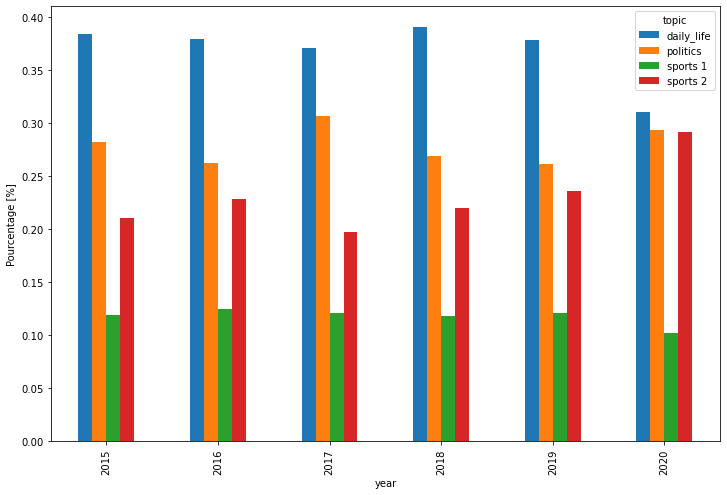

In [6]:
quotes_politicians.groupby('year')['topic'].value_counts().div(quotes_politicians.groupby('year').size()).unstack().plot.bar(figsize=[12,8], ylabel='Pourcentage [%]')

In [ ]:
quotes_politicians.to_csv('quotes_politicians_topic.csv')